<a href="https://colab.research.google.com/github/ClovisDyArx/SSL/blob/main/TP_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : apprentissage multimodal


Dans ce TP, nous allons utiliser le modèle d'apprentissage, FashionCLIP, pré-entraîné sur des images ainsi que des descriptions en langage naturel. Plus particulièrement, nous allons considérer deux cas d'usage :

*   **Moteur de recherche d'images :** il s'agit de trouver, à partir d'une requête en langage naturel, l'image correspondante.

*   **Classification zero-shot :** il s'agit simplement de construire un classifieur d'images (faire correspondre un label à une image).



## Dataset

Nous allons dans un premier temps télécharger les données. Celles-ci provienennt de [Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).

In [1]:
%%capture
!pip install gdown
!gdown "1igAuIEW_4h_51BG1o05WS0Q0-Cp17_-t&confirm=t"
!unzip data

### Modèle FashionCLIP

Nous allons également télécharger le modèle pré-entraîné.

In [2]:
%%capture
!pip install -U fashion-clip

In [3]:
import sys
#sys.path.append("fashion-clip/")
from fashion_clip.fashion_clip import FashionCLIP
import pandas as pd
import numpy as np
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from IPython.display import display
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [4]:
%%capture
fclip = FashionCLIP('fashion-clip')

FashionCLIP, à l'instar de CLIP, crée un espace vectoriel partagé pour les images et le texte. Cela permet de nombreuses applications, telles que la recherche (trouver l'image la plus similaire à une requête donnée) ou la classification zero-shot.

Il y a principalement deux composants : un encodeur d'image (pour générer un vecteur à partir d'une image) et un encodeur de texte (pour générer un vecteur à partir d'un texte).










<img src="https://miro.medium.com/v2/resize:fit:1400/0*FLNMtW6jK51fm7Og"  width="400">



Nous allons télécharger les données que nous allons ensuite nettoyer.

In [5]:
articles = pd.read_csv("data_for_fashion_clip/articles.csv")

# Supprimer les éléments ayant la même description
subset = articles.drop_duplicates("detail_desc").copy()

# upprimer les images dont la catégrie n'est pas renseignée
subset = subset[~subset["product_group_name"].isin(["Unknown"])]

# Garder seulement les descriptions dont la longueur est inférieure à 40 tokens
subset = subset[subset["detail_desc"].apply(lambda x : 4 < len(str(x).split()) < 40)]

# Supprimer les articles qui ne sont pas suffisamment fréquents dans le jeu de données
most_frequent_product_types = [k for k, v in dict(Counter(subset["product_type_name"].tolist())).items() if v > 10]
subset = subset[subset["product_type_name"].isin(most_frequent_product_types)]

subset.head(3)

article_id  product_code                   prod_name  product_type_no  \
0   108775044        108775                   Strap top              253   
1   176754003        176754  2 Row Braided Headband (1)               74   
3   189634031        189634           Long Leg Leggings              273   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1   Hair/alice band         Accessories                  1010016   
3   Leggings/Tights  Garment Lower body                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                 10             White  ...   
1                     Solid                 17   Yellowish Brown  ...   
3                     Solid                 93        Dark Green  ...   

    department_name index_code          index_name index_group_no  \
0      Jersey Basic          A          Ladieswear              1   
1  Hair Accessories          C  Ladies Accessories              1   
3           Basic 1          D             Divided              2   

   index_group_name section_no              section_name garment_group_no  \
0        Ladieswear         16    Womens Everyday Basics             1002   
1        Ladieswear         66  Womens Small accessories             1019   
3           Divided         51            Divided Basics             1002   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1         Accessories  Two-strand hairband with braids in imitation s...  
3        Jersey Basic  Leggings in stretch jersey with an elasticated...  

[3 rows x 25 columns]

In [6]:
subset.to_csv("subset_data.csv", index=False)
f"Il y a {len(subset)} éléments dans le dataset"

'Il y a 3104 éléments dans le dataset'

## Moteur de recherche d'images

Constuire un moteur de recherche qui permet, à partir d'une description en langage naturel, de récupérer l'image correspondante. Mesurer ses performances (précision).

<img src="https://miro.medium.com/v2/resize:fit:1400/1*cnKHgLAumVyuHuK9pkqr7A.gif"  width="800">


In [7]:
batch_size = 32

In [8]:
images = ["data_for_fashion_clip/" + str(k) + ".jpg" for k in subset["article_id"].tolist()]
texts = subset["detail_desc"].tolist()

# Créer les représentations vectorielles (embeddings) des images et des descriptions.
image_embeddings = fclip.encode_images(images, batch_size=batch_size)
text_embeddings = fclip.encode_text(texts, batch_size=batch_size)

100%|██████████| 97/97 [02:24<00:00,  1.49s/it]


Map:   0%|          | 0/3104 [00:00<?, ? examples/s]

100%|██████████| 97/97 [00:05<00:00, 16.84it/s]


In [9]:
image_embeddings = image_embeddings/np.linalg.norm(image_embeddings, ord=2, axis=-1, keepdims=True)
text_embeddings = text_embeddings/np.linalg.norm(text_embeddings, ord=2, axis=-1, keepdims=True)

In [10]:
print(image_embeddings.shape)
print(text_embeddings.shape)

(3104, 512)
(3104, 512)


In [11]:
def search_engine(query: str, batch_size: int = 32):
    query_embedding = fclip.encode_text([query], batch_size=batch_size)
    query_embedding = query_embedding/np.linalg.norm(query_embedding, ord=2, axis=-1, keepdims=True)

    similarities = cosine_similarity(query_embedding, image_embeddings)[0]

    best_match_index = np.argmax(similarities).item()

    best_match = subset.iloc[best_match_index]

    article_id = best_match['article_id']
    path = f"/content/data_for_fashion_clip/{article_id}.jpg"

    img = Image.open(path)
    display(img)

    return best_match

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 50.66it/s]


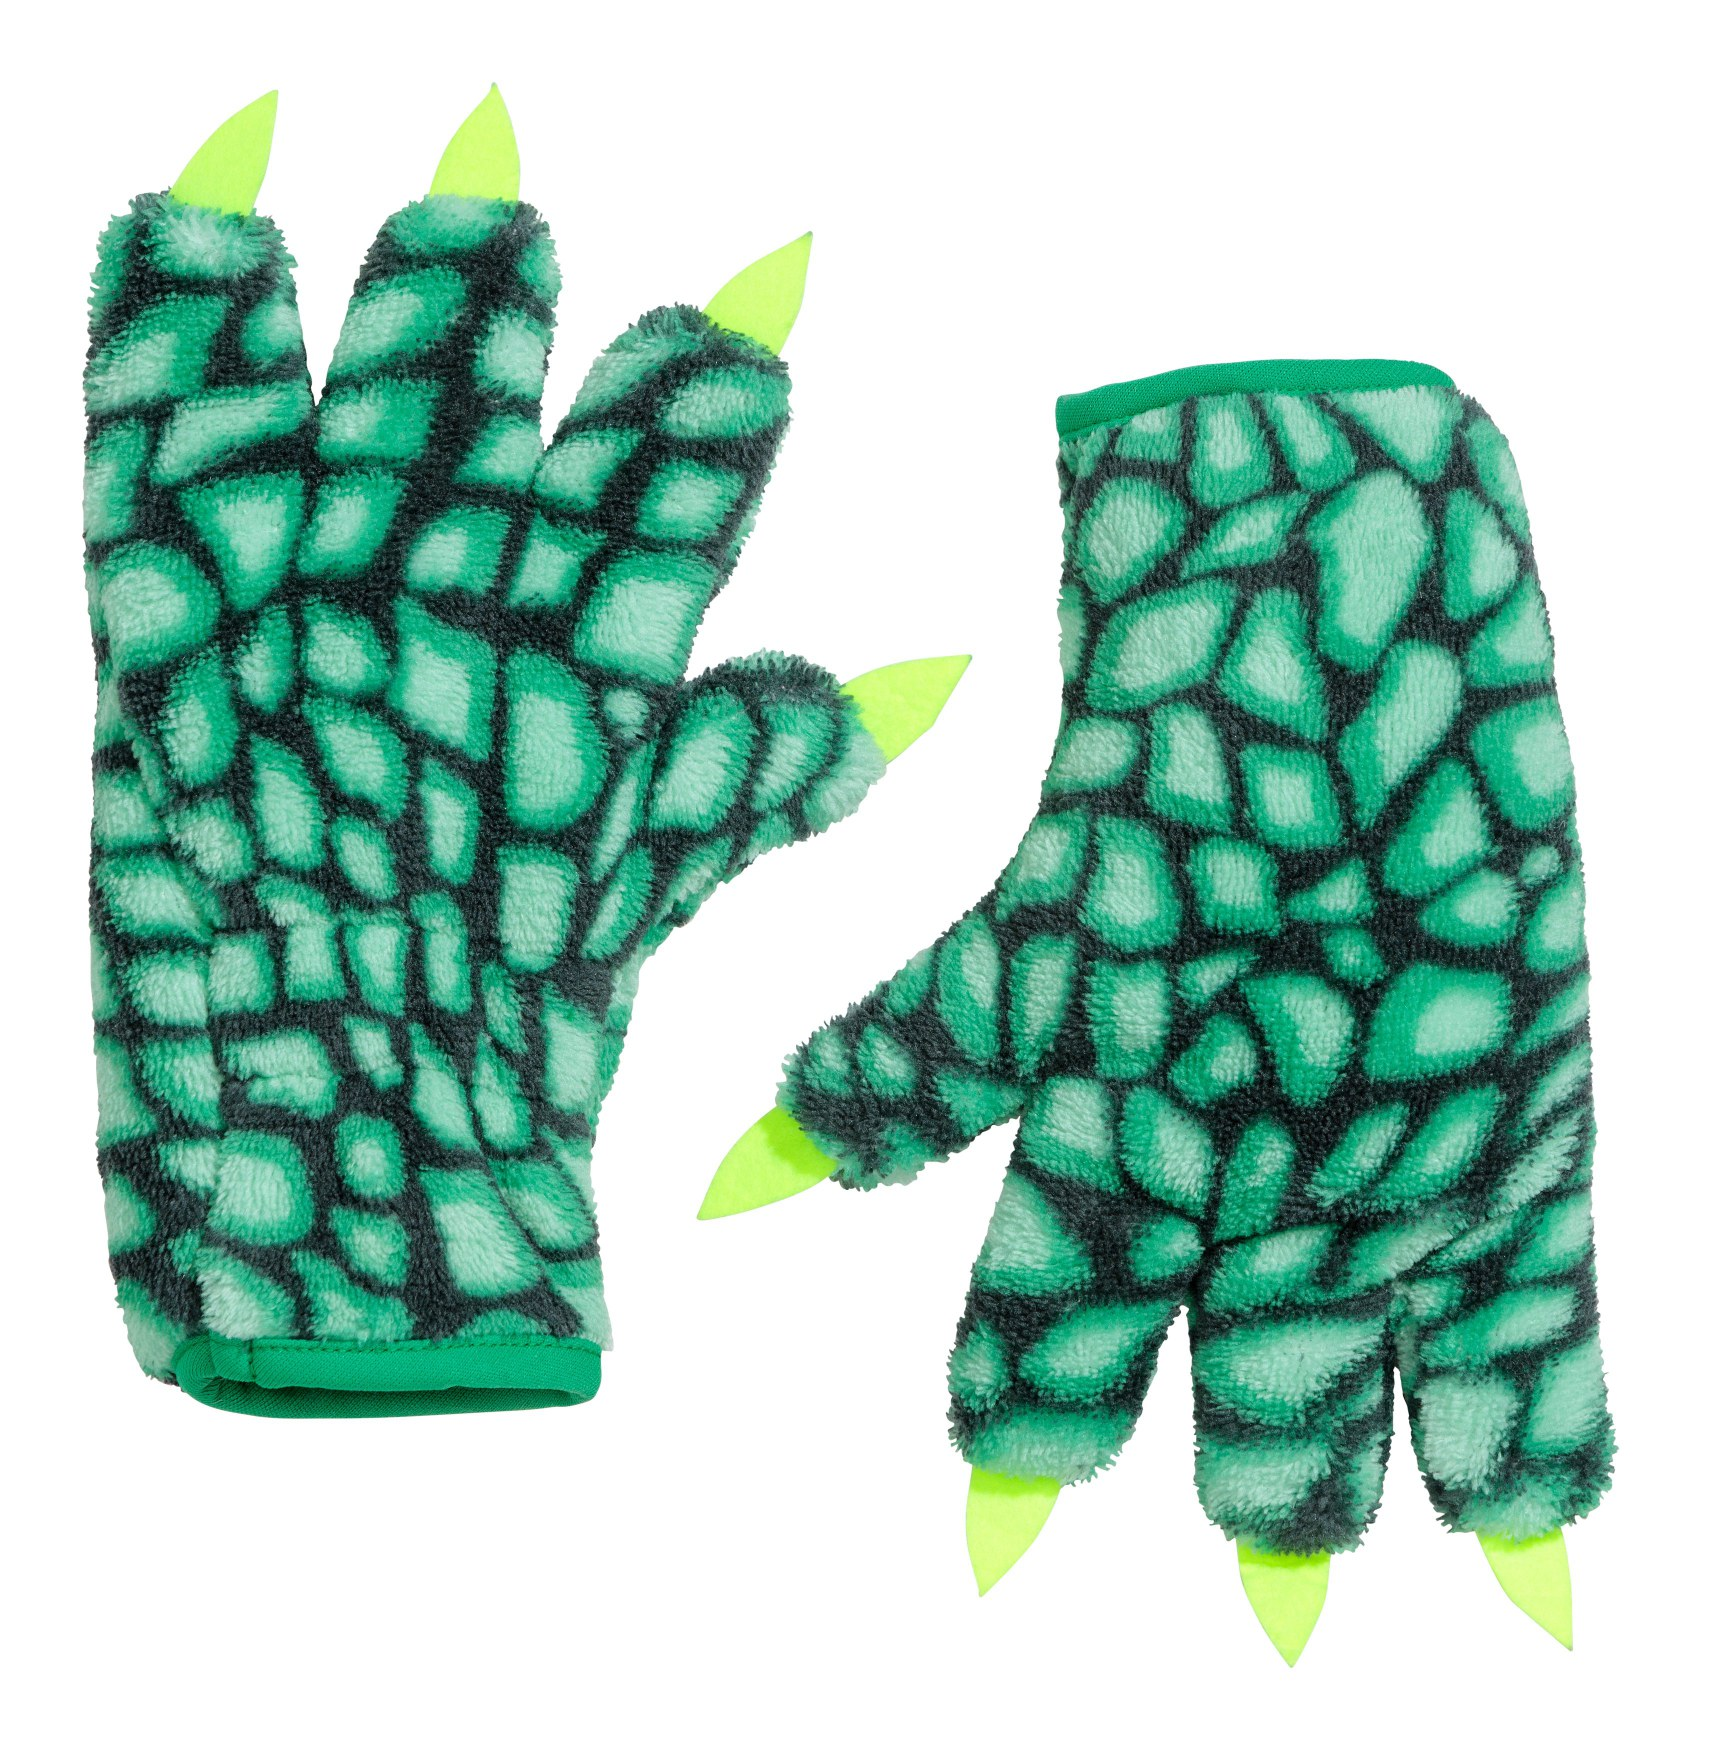

article_id                                                              619695001
product_code                                                               619695
prod_name                                                       Dragon Gloves own
product_type_no                                                                71
product_type_name                                                          Gloves
product_group_name                                                    Accessories
graphical_appearance_no                                                   1010001
graphical_appearance_name                                        All over pattern
colour_group_code                                                              92
colour_group_name                                                           Green
perceived_colour_value_id                                                       5
perceived_colour_value_name                                                Bright
perceived_colour_master_id                                                     19
perceived_colour_master_name                                                Green
department_no                                                                4216
department_name                                                     Dress-up Boys
index_code                                                                      J
index_name                                         Children Accessories, Swimwear
index_group_no                                                                  4
index_group_name                                                    Baby/Children
section_no                                                                     43
section_name                                       Kids Accessories, Swimwear & D
garment_group_no                                                             1019
garment_group_name                                                    Accessories
detail_desc                     Fancy dress gloves in soft printed fleece with...
Name: 1024, dtype: object

In [12]:
search_engine("green goblin")

Notre moteur de recherche semble bien fonctionner.

In [13]:
def compute_top5_accuracy(batch_size: int = 32, samples_to_test : int = 10):
    correct_count = 0

    for idx, row in subset.iterrows():
        if idx >= samples_to_test:
            break

        ground_truth_query = row['detail_desc']

        query_embedding = fclip.encode_text([ground_truth_query], batch_size=batch_size)
        query_embedding = query_embedding / np.linalg.norm(query_embedding, ord=2, axis=-1, keepdims=True)

        similarities = cosine_similarity(query_embedding, image_embeddings)[0]

        top_5_indices = np.argsort(similarities)[-5:][::-1]

        ground_truth_article_id = row['article_id']
        top_5_article_ids = subset.iloc[top_5_indices]['article_id'].values

        if ground_truth_article_id in top_5_article_ids:
            correct_count += 1

    top5_accuracy = (correct_count / samples_to_test) * 100
    return top5_accuracy

In [14]:
top5_accuracy = compute_top5_accuracy(batch_size=32, samples_to_test=10)

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 60.15it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 44.50it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 37.35it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 80.36it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 55.68it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 51.69it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 76.03it/s]


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

1it [00:00, 50.79it/s]


In [15]:
print(top5_accuracy)

40.0


# Classification zero-shot

Construite un classsifieur d'images (prédire le label d'une image). Mesurer ses performances.

<img src="https://miro.medium.com/v2/resize:fit:1400/1*No6ZONpQMIcfFaNMOI5oNw.gif"  width="800">



On utilisera les types de produit comme labels.

In [30]:
labels = subset["product_type_name"].tolist()
labels

['Vest top',
 'Hair/alice band',
 'Leggings/Tights',
 'Vest top',
 'T-shirt',
 'Sneakers',
 'Sunglasses',
 'Cardigan',
 'Gloves',
 'Underwear Tights',
 'Hoodie',
 'Other shoe',
 'T-shirt',
 'T-shirt',
 'Shorts',
 'Jumpsuit/Playsuit',
 'Underwear Tights',
 'Underwear Tights',
 'Underwear Tights',
 'Cardigan',
 'T-shirt',
 'Dress',
 'Trousers',
 'Belt',
 'Socks',
 'Underwear Tights',
 'Leggings/Tights',
 'Underwear bottom',
 'Bodysuit',
 'Trousers',
 'Hat/beanie',
 'Scarf',
 'Dress',
 'Jacket',
 'Other accessories',
 'Bra',
 'Trousers',
 'Leggings/Tights',
 'Trousers',
 'Belt',
 'Underwear bottom',
 'Scarf',
 'Leggings/Tights',
 'Bodysuit',
 'Swimwear bottom',
 'Trousers',
 'T-shirt',
 'Blazer',
 'Top',
 'Top',
 'Trousers',
 'Shorts',
 'Socks',
 'Polo shirt',
 'Sweater',
 'Sweater',
 'T-shirt',
 'Leggings/Tights',
 'T-shirt',
 'Trousers',
 'Trousers',
 'Trousers',
 'Top',
 'Underwear bottom',
 'Shorts',
 'Jacket',
 'Trousers',
 'Trousers',
 'T-shirt',
 'Socks',
 'Vest top',
 'Sweater',
 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings, labels, test_size=0.2, random_state=42
)

In [32]:
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [33]:
y_pred = classifier.predict(X_test)

print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              Bag       0.73      1.00      0.84         8
       Ballerinas       0.00      0.00      0.00         4
             Belt       1.00      0.67      0.80         3
       Bikini top       1.00      0.56      0.71         9
           Blazer       1.00      0.88      0.93         8
           Blouse       0.57      0.67      0.62        18
         Bodysuit       1.00      0.17      0.29         6
            Boots       1.00      0.67      0.80         6
              Bra       0.78      1.00      0.88         7
       Cap/peaked       0.57      1.00      0.73         4
         Cardigan       1.00      0.75      0.86         4
             Coat       0.00      0.00      0.00         2
            Dress       0.75      0.89      0.81        66
        Dungarees       0.00      0.00      0.00         3
          Earring       0.94      1.00      0.97        15
      Garment Set       0.50      0.20      0.29       

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


On obtient de très bon résultats. On a un score de 0 sur top mais c'est un mot peu précis.

Ci-dessous une démonstration du classifier.

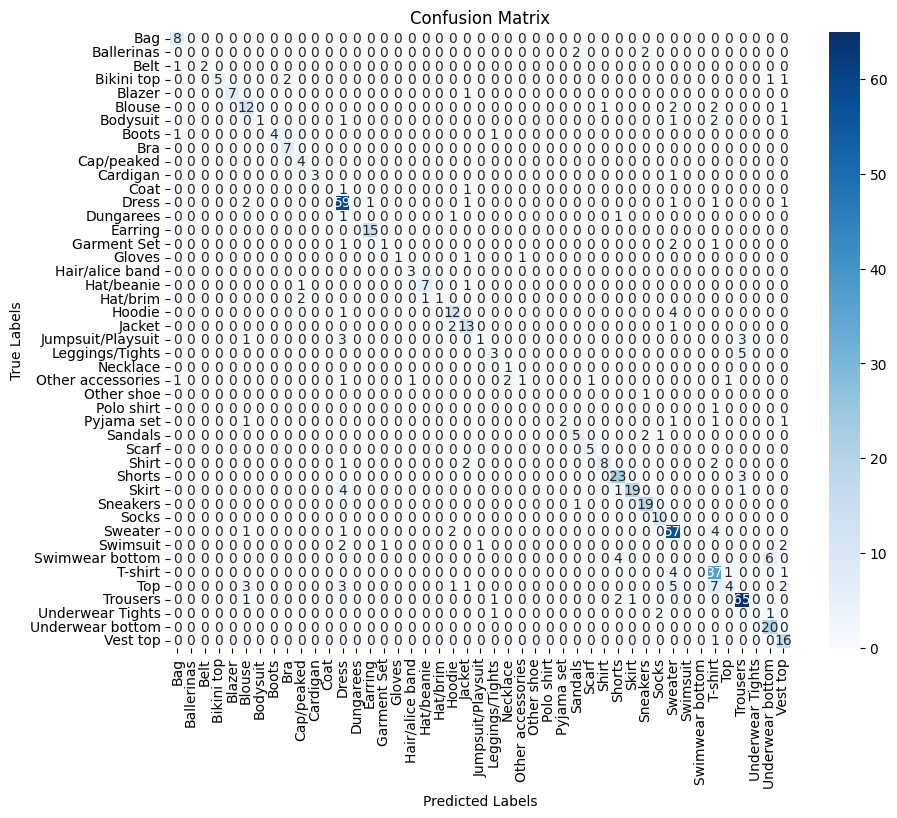

In [34]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [36]:
example_image_path = "/content/data_for_fashion_clip/215303001.jpg"
example_image_embedding = fclip.encode_images([example_image_path], batch_size=batch_size)
example_image_embedding = example_image_embedding / np.linalg.norm(example_image_embedding, ord=2, axis=-1, keepdims=True)


predicted_label = classifier.predict(example_image_embedding)
print(f"Predicted label for {example_image_path}: {predicted_label[0]}")

1it [00:00, 20.07it/s]

Predicted label for /content/data_for_fashion_clip/215303001.jpg: Sunglasses


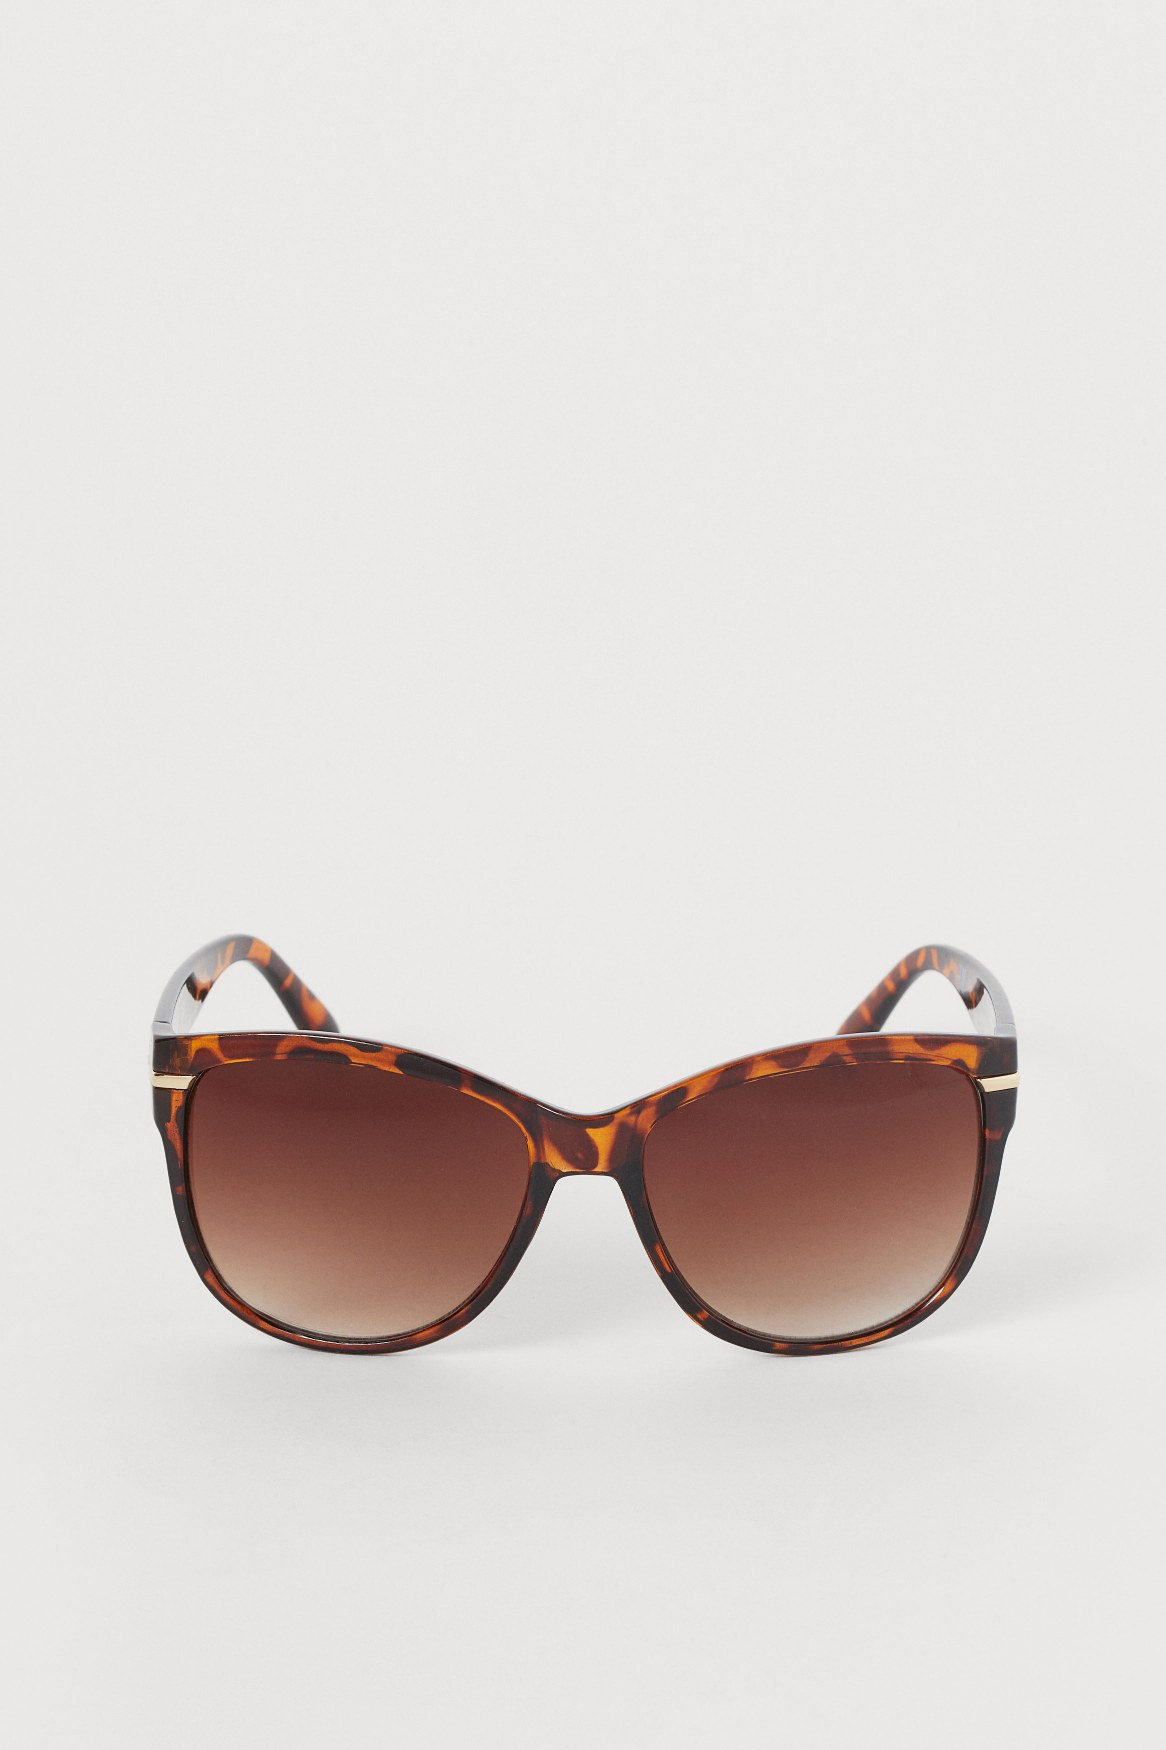

In [37]:
img = Image.open(example_image_path)
display(img)